In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import backend as K


from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [3]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
Tamano de la serie temporal 2
shape train/val (17396, 96, 1, 1) (8659, 96, 1, 1) (8587, 96, 1, 1)
(17396, 96, 1, 1)
/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/bl

In [4]:
n_neurons = int(2/3*(X_train.shape[1]*X_train.shape[2]))


inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
time2vec = T2V(128)(inputs)
lstm_out = tfk.layers.LSTM(n_neurons,return_sequences=True)(time2vec)
lstm_out = tfk.layers.LSTM(n_neurons,)(lstm_out)
outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(lstm_out)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
t2v (T2V)                    (None, 96, 129)           12608     
_________________________________________________________________
lstm (LSTM)                  (None, 96, 64)            49664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 95,686
Trainable params: 95,686
Non-trainable params: 0
_________________________________________________________________


In [5]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=50, 
                    validation_data=(X_val, y_val)) 


loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion
#val_mse = history.history['val_mse']    #validacion
#mse = history.history['mse']    #validacion


Epoch 1/50
68/68 [==============================] - 46s 617ms/step - loss: 0.7641 - mean_absolute_error: 0.7281 - val_loss: 0.1624 - val_mean_absolute_error: 0.3032
Epoch 2/50
68/68 [==============================] - 38s 560ms/step - loss: 0.1294 - mean_absolute_error: 0.2713 - val_loss: 0.0884 - val_mean_absolute_error: 0.2256
Epoch 3/50
68/68 [==============================] - 38s 565ms/step - loss: 0.0806 - mean_absolute_error: 0.2121 - val_loss: 0.0804 - val_mean_absolute_error: 0.2119
Epoch 4/50
68/68 [==============================] - 38s 559ms/step - loss: 0.0733 - mean_absolute_error: 0.2018 - val_loss: 0.0746 - val_mean_absolute_error: 0.2045
Epoch 5/50
68/68 [==============================] - 39s 578ms/step - loss: 0.0657 - mean_absolute_error: 0.1903 - val_loss: 0.0803 - val_mean_absolute_error: 0.2161
Epoch 6/50
68/68 [==============================] - 39s 574ms/step - loss: 0.0643 - mean_absolute_error: 0.1879 - val_loss: 0.0654 - val_mean_absolute_error: 0.1897
Epoch 7/50

In [15]:
model.save('LSTMT2VEC_150_2.h5')

NotImplementedError: Layer T2V has arguments in `__init__` and therefore must override `get_config`.

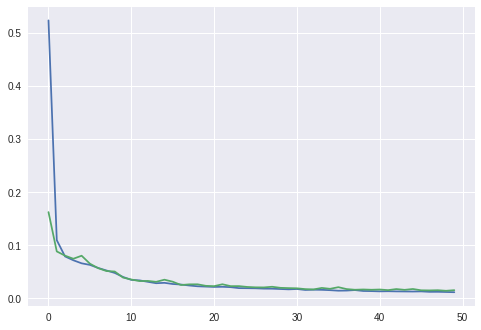

In [6]:
plt.plot(loss)
plt.plot(val_loss)
plt.show()

In [10]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [11]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [12]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [13]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 245.334539
t+2 MSE: 320.947186
t+3 MSE: 372.579301
t+4 MSE: 415.786691
t+5 MSE: 457.358457
t+6 MSE: 513.686150
validacion
t+1 MSE: 247.709608
t+2 MSE: 318.078907
t+3 MSE: 361.491603
t+4 MSE: 402.715228
t+5 MSE: 445.980679
t+6 MSE: 505.226921


In [14]:
(245.334539 + 320.947186 + 372.579301 + 415.786691 + 457.358457 + 513.686150)/6

387.61538733333333